 # [Pseudo enzymes](https://en.wikipedia.org/wiki/Pseudoenzyme)

 # 研究方法

 寻找一些典型的Pseudo Enzymes，使用blastp寻找与其最相似的真酶（最好在测试集或者验证集中）然后分配最相似的酶的反应给该Pseudo Enzyme，使用EasIFA预测Pseudo Enzyme-Reaction以及真酶-Reaction对儿，检验EasIFA是否能对Pseudo Enzyme预测全阴性

In [1]:
# %%
import pandas as pd
import os
from tqdm.auto import tqdm
from pandarallel import pandarallel
from rdkit import Chem
from tqdm import tqdm as top_tqdm



In [2]:
# %%
def get_structure_sequence(pdb_file):
    try:
        mol = Chem.MolFromPDBFile(pdb_file)
        protein_sequence = Chem.MolToSequence(mol)
    except:
        protein_sequence = ""
    return protein_sequence


def multiprocess_structure_check(df, nb_workers, pdb_file_path):

    if nb_workers != 0:

        pandarallel.initialize(nb_workers=nb_workers, progress_bar=True)
        df["pdb_files"] = df["alphafolddb-id"].parallel_apply(
            lambda x: os.path.join(pdb_file_path, f"AF-{x}-F1-model_v4.pdb")
        )
        df["aa_sequence_calculated"] = df["pdb_files"].parallel_apply(
            lambda x: get_structure_sequence(x)
        )
    else:
        top_tqdm.pandas(desc="pandas bar")
        df["pdb_files"] = df["alphafolddb-id"].progress_apply(
            lambda x: os.path.join(pdb_file_path, f"AF-{x}-F1-model_v4.pdb")
        )
        df["aa_sequence_calculated"] = df["pdb_files"].progress_apply(
            lambda x: get_structure_sequence(x)
        )

    df["is_valid"] = df["aa_sequence_calculated"] == df["aa_sequence"]

    return df


def get_blast_database(dir, fasta_path):
    database_df = pd.DataFrame()
    csv_fnames = os.listdir(dir)
    pbar = tqdm(csv_fnames, total=len(csv_fnames))
    for fname in pbar:
        df = pd.read_csv(os.path.join(dir, fname))
        df = df[["alphafolddb-id", "aa_sequence", "site_labels", "site_types"]]
        database_df = pd.concat([database_df, df])

    database_df = database_df.drop_duplicates(
        subset=["alphafolddb-id", "aa_sequence", "site_labels", "site_types"]
    ).reset_index(drop=True)
    database_df["alphafolddb-id"] = database_df["alphafolddb-id"].apply(
        lambda x: x.replace(";", "")
    )

    with open(fasta_path, "w", encoding="utf-8") as f:
        for idx, row in tqdm(database_df.iterrows(), total=len(database_df)):
            f.write(">{}\n".format(row["alphafolddb-id"]))
            f.write("{}\n".format(row["aa_sequence"]))
    return database_df


def get_multi_blast_database(dir_list, fasta_path):
    merge_database_df = pd.DataFrame()
    for dir in dir_list:
        database_df = pd.DataFrame()
        csv_fnames = os.listdir(dir)
        pbar = tqdm(csv_fnames, total=len(csv_fnames))
        for fname in pbar:
            df = pd.read_csv(os.path.join(dir, fname))
            df = df[["alphafolddb-id", "aa_sequence", "site_labels", "site_types"]]
            database_df = pd.concat([database_df, df])
        merge_database_df = pd.concat([merge_database_df, database_df])
    merge_database_df = merge_database_df.drop_duplicates(
        subset=["alphafolddb-id", "aa_sequence", "site_labels", "site_types"]
    ).reset_index(drop=True)
    merge_database_df["alphafolddb-id"] = merge_database_df["alphafolddb-id"].apply(
        lambda x: x.replace(";", "")
    )

    os.makedirs(os.path.dirname(fasta_path), exist_ok=True)
    with open(fasta_path, "w", encoding="utf-8") as f:
        for idx, row in tqdm(
            merge_database_df.iterrows(), total=len(merge_database_df)
        ):
            f.write(">{}\n".format(row["alphafolddb-id"]))
            f.write("{}\n".format(row["aa_sequence"]))
    return merge_database_df


def get_query_database(path, fasta_path, pdb_file_path):
    database_df = pd.read_csv(path)
    database_df = database_df[
        ["alphafolddb-id", "aa_sequence", "site_labels", "site_types"]
    ]
    database_df["alphafolddb-id"] = database_df["alphafolddb-id"].apply(
        lambda x: x.replace(";", "")
    )

    database_df = multiprocess_structure_check(
        database_df, nb_workers=12, pdb_file_path=pdb_file_path
    )

    write_database_df = database_df.drop_duplicates(
        subset=["alphafolddb-id", "aa_sequence", "site_labels", "site_types"]
    ).reset_index(drop=True)

    with open(fasta_path, "w", encoding="utf-8") as f:
        for idx, row in tqdm(
            write_database_df.iterrows(), total=len(write_database_df)
        ):
            f.write(">{}\n".format(row["alphafolddb-id"]))
            f.write("{}\n".format(row["aa_sequence"]))
    return database_df



In [3]:
# %%
work_space = "./pseudo_enzymes_workspace"
dataset_path = "../../dataset/ec_site_dataset/uniprot_ecreact_cluster_split_merge_dataset_limit_100"
merge_untrain_fasta_name = "merge_untrain_fasta"
merge_untrain_fasta_path = os.path.join(work_space, f"{merge_untrain_fasta_name}.fasta")
qurey_fasta_path = os.path.join("./", "qurey_fasta")
blast_out_path = os.path.join("./", "blast_out")
os.makedirs(work_space, exist_ok=True)



In [4]:
# %%
merge_untrain_database = get_multi_blast_database(
    [
        os.path.join(dataset_path, "valid_dataset"),
        os.path.join(dataset_path, "test_dataset"),
    ],
    fasta_path=merge_untrain_fasta_path,
)


  0%|          | 0/1011 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2706 [00:00<?, ?it/s]

In [5]:
# %%
import requests
import subprocess
from Bio import SeqIO
from io import StringIO


def fetch_fasta(uniprot_id):
    url = f"https://www.uniprot.org/uniprot/{uniprot_id}.fasta"
    response = requests.get(url)
    if response.status_code == 200:
        fasta_data = response.text
        # Use BioPython to read the fasta data
        fasta_io = StringIO(fasta_data)  # Create a string stream to read the fasta
        record = next(SeqIO.parse(fasta_io, "fasta"))  # Read the fasta data
        sequence_length = len(record.seq)  # Get the length of the sequence
        print(f"UniProt: {uniprot_id} Sequence Length: {sequence_length}")
        return fasta_data
    else:
        raise Exception(f"Failed to fetch FASTA for UniProt ID {uniprot_id}")


def save_fasta(fasta_sequence, filename):
    with open(filename, "w") as file:
        file.write(fasta_sequence)


def make_blast_db(fasta_path, db_name, db_type="prot"):

    if not os.path.exists(db_name + ".pin"):
        command = f"makeblastdb -in {fasta_path} -dbtype {db_type} -out {db_name}"
        subprocess.run(command, shell=True)
        print(f"BLAST database created: {db_name}")
    else:
        print(f"BLAST database {db_name} already exists.")


def run_local_blast(uniprot_id, fasta_file, blast_db, output_path):

    os.makedirs(output_path, exist_ok=True)
    output_file = os.path.join(output_path, f"blast_{uniprot_id}.csv")
    command = f"blastp -query {fasta_file} -db {blast_db} -out {output_file} -evalue 0.001 -outfmt 6 -num_threads 16"
    subprocess.run(command, shell=True)
    print(f"BLAST results saved to {output_file}")
    return output_file


def read_blast_results(csv_file):

    column_headers = [
        "Query ID",
        "Subject ID",
        "% Identity",
        "Alignment Length",
        "Mismatches",
        "Gap Opens",
        "Query Start",
        "Query End",
        "Subject Start",
        "Subject End",
        "E-value",
        "Bit Score",
    ]
    df = pd.read_csv(csv_file, sep="\t", header=None)
    df.columns = column_headers

    return df


def qurey_by_blast(uniprot_id, qurey_fasta_path, blast_db, blast_out_path):
    os.makedirs(qurey_fasta_path, exist_ok=True)
    fasta_sequence = fetch_fasta(uniprot_id)
    fasta_file = os.path.join(qurey_fasta_path, f"{uniprot_id}.fasta")
    save_fasta(fasta_sequence, fasta_file)
    output_csv = run_local_blast(
        uniprot_id, fasta_file, blast_db=blast_db, output_path=blast_out_path
    )
    return read_blast_results(output_csv)



In [6]:
# %%
from collections import defaultdict
from IPython.display import display, HTML, IFrame
import sys

sys.path.append("../../")
from webapp.utils import (
    EasIFAInferenceAPI,
    UniProtParserMysql,
    default_ec_site_model_state_path,
    get_structure_html_and_active_data,
    cmd,
)

unprot_mysql_parser = UniProtParserMysql(
    mysql_config_path="../../webapp/mysql_config.json"
)
easifa_predictor = EasIFAInferenceAPI(
    model_checkpoint_path=default_ec_site_model_state_path
)

# pred_active_site_labels = easifa_predictor.inference(
#                     rxn=rxn, enzyme_structure_path=enzyme_structure_path
#                 )

# structure_html, active_data = get_structure_html_and_active_data(
#     enzyme_structure_path=enzyme_structure_path,
#     site_labels=pred_active_site_labels,
#     view_size=(600, 600),
# )


def inference(rxn_smiles, enzyme_structure_path):
    pred_active_site_labels = easifa_predictor.inference(
        rxn=rxn_smiles, enzyme_structure_path=enzyme_structure_path
    )
    structure_html, active_data = get_structure_html_and_active_data(
        enzyme_structure_path=enzyme_structure_path,
        site_labels=pred_active_site_labels,
        view_size=(600, 600),
    )
    return structure_html, active_data


def pred_for_uniprot_id(uniprot_id):  # 输入Pseudo enzymes的uniprot id
    try:
        ec_simiar_df = qurey_by_blast(
            uniprot_id=uniprot_id,
            qurey_fasta_path=qurey_fasta_path,
            blast_db=merge_untrain_fasta_path,
            blast_out_path=blast_out_path,
        )

        results = defaultdict(dict)

        if not ec_simiar_df.empty:  # 只取最像的一个，E-value < 10-5
            if ec_simiar_df["E-value"].min() > 0.00001:
                print("No Similar Enzyme Results!")
                return None

            qurey_uniprot_id = ec_simiar_df["Subject ID"].tolist()[0]
            evalue = ec_simiar_df["E-value"].tolist()[0]
            sequence_identity =ec_simiar_df["% Identity"].tolist()[0]
            print(f"Similar Enzyme UniProtID={qurey_uniprot_id}, E-value={evalue}, % Identity={sequence_identity}")
            query_data, _, _ = unprot_mysql_parser.query_from_uniprot(qurey_uniprot_id)
            _, query_results_df, _, _ = query_data

            rxn_smiles = query_results_df["rxn_smiles"].tolist()[
                0
            ]  # Pseudo enzymes 共享 rxn_smiles
            enzyme_structure_path = query_results_df["pdb_fpath"].tolist()[0]
            if not os.path.exists(enzyme_structure_path):  # 真酶结构
                enzyme_structure_path = os.path.join(
                    unprot_mysql_parser.unprot_parser.alphafolddb_folder,
                    f"AF-{qurey_uniprot_id}-F1-model_v4.pdb",
                )
                cmd(
                    unprot_mysql_parser.unprot_parser.download_alphafolddb_url_template.format(
                        enzyme_structure_path, qurey_uniprot_id
                    )
                )

            (
                results["Enzyme Result"]["structure_html"],
                results["Enzyme Result"]["active_data"],
            ) = inference(rxn_smiles, enzyme_structure_path)
            results["Enzyme Result"]["uniprot_id"] = qurey_uniprot_id

            pseudoenzyme_structure_path = os.path.join(
                unprot_mysql_parser.unprot_parser.alphafolddb_folder,
                f"AF-{uniprot_id}-F1-model_v4.pdb",
            )
            if not os.path.exists(pseudoenzyme_structure_path):  # 伪酶结构
                cmd(
                    unprot_mysql_parser.unprot_parser.download_alphafolddb_url_template.format(
                        pseudoenzyme_structure_path, uniprot_id
                    )
                )
            (
                results["Pseudoenzyme Result"]["structure_html"],
                results["Pseudoenzyme Result"]["active_data"],
            ) = inference(rxn_smiles, pseudoenzyme_structure_path)
            results["Pseudoenzyme Result"]["uniprot_id"] = uniprot_id
            return results

        else:
            print("No Results!!!")
            return None
    except:
        print("erro")
        return None



/home/xiaoruiwang/software/miniconda3/envs/py38/lib/python3.8/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


[Errno 2] No such file or directory: '../../webapp/mysql_config.json'


/home/xiaoruiwang/data/ubuntu_work_beta/single_step_work/EasIFA_v2/script/pseudo_enzyme_study/../../model_structure/esm_layer.py:297: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


Reaction attention model from scratch...
Loaded checkpoint from /home/xiaoruiwang/data/ubuntu_work_beta/single_step_work/EasIFA_v2/checkpoints/enzyme_site_type_predition_model/train_in_uniprot_ecreact_cluster_split_merge_dataset_limit_100_at_2023-06-14-11-04-55/global_step_70000


In [7]:
# %%
def show_results(uniprot_id):
    results = pred_for_uniprot_id(uniprot_id=uniprot_id)
    print("Pseudo Enzymes")
    display(HTML(results["Pseudoenzyme Result"]["structure_html"]))
    display(results["Pseudoenzyme Result"]["active_data"])
    display(IFrame(f'https://www.uniprot.org/uniprotkb/{uniprot_id}/entry', width=1200, height=900))
    print("Similar Enzymes")
    display(HTML(results["Enzyme Result"]["structure_html"]))
    display(results["Enzyme Result"]["active_data"])
    display(IFrame('https://www.uniprot.org/uniprotkb/{}/entry'.format(results["Enzyme Result"]['uniprot_id']), width=1200, height=900))



In [8]:
# %%
make_blast_db(merge_untrain_fasta_path, db_name=merge_untrain_fasta_path)


BLAST database ./pseudo_enzymes_workspace/merge_untrain_fasta.fasta already exists.


In [9]:
# %%
qurey_by_blast(
    uniprot_id="Q8CID3",
    qurey_fasta_path=qurey_fasta_path,
    blast_db=merge_untrain_fasta_path,
    blast_out_path=blast_out_path,
)


UniProt: Q8CID3 Sequence Length: 541
BLAST results saved to ./blast_out/blast_Q8CID3.csv


,Query ID,Subject ID,% Identity,Alignment Length,Mismatches,Gap Opens,Query Start,Query End,Subject Start,Subject End,E-value,Bit Score
0,sp|Q8CID3|FA20A_MOUSE,Q9XTW2,38.12,383,212,7,158,537,131,491,1.910000e-83,265


In [10]:
# %%
# qurey_by_blast(uniprot_id='Q8LGB6', qurey_fasta_path=qurey_fasta_path, blast_db=merge_untrain_fasta_path, blast_out_path=blast_out_path)


In [11]:
# %%
# qurey_by_blast(uniprot_id='Q9C0K7', qurey_fasta_path=qurey_fasta_path, blast_db=merge_untrain_fasta_path, blast_out_path=blast_out_path)


In [12]:
# %%
# qurey_by_blast(uniprot_id='Q9LFL7', qurey_fasta_path=qurey_fasta_path, blast_db=merge_untrain_fasta_path, blast_out_path=blast_out_path)


In [13]:
# # %%
# uniprot_id='Q9Y616'
# show_results(uniprot_id=uniprot_id)


In [14]:
# %%
# uniprot_id='Q5ZK47'
# show_results(uniprot_id=uniprot_id)


In [15]:
# %%
# uniprot_id='Q5BFB1'
# show_results(uniprot_id=uniprot_id)


In [16]:
# %%
uniprot_id='Q0WSK8'
show_results(uniprot_id=uniprot_id)


UniProt: Q0WSK8 Sequence Length: 356
BLAST results saved to ./blast_out/blast_Q0WSK8.csv
Similar Enzyme UniProtID=Q9SVY5, E-value=1.48e-49, % Identity=32.948
[Errno 2] No such file or directory: '../../webapp/mysql_config.json'
Pseudo Enzymes


[(94, 'LYS', '#FF0000', 'Binding Site')]

Similar Enzymes


[(66, 'VAL', '#FF0000', 'Binding Site'),
 (67, 'SER', '#FF0000', 'Binding Site'),
 (68, 'GLN', '#FF0000', 'Binding Site'),
 (69, 'ASP', '#FF0000', 'Binding Site'),
 (70, 'VAL', '#FF0000', 'Binding Site'),
 (71, 'TYR', '#FF0000', 'Binding Site'),
 (72, 'TYR', '#FF0000', 'Binding Site'),
 (73, 'LYS', '#FF0000', 'Binding Site'),
 (74, 'TRP', '#FF0000', 'Binding Site'),
 (87, 'LYS', '#FF0000', 'Binding Site'),
 (191, 'ASP', '#00B050', 'Catalytic Site')]

In [17]:
# %%
# uniprot_id='P0CD65'
# show_results(uniprot_id=uniprot_id)


In [18]:
# %%
# uniprot_id='Q9SVZ0'
# show_results(uniprot_id=uniprot_id)


In [19]:
# %%
uniprot_id='Q96RU8'
show_results(uniprot_id=uniprot_id)


UniProt: Q96RU8 Sequence Length: 372
BLAST results saved to ./blast_out/blast_Q96RU8.csv
Similar Enzyme UniProtID=O74536, E-value=5.87e-36, % Identity=33.645
[Errno 2] No such file or directory: '../../webapp/mysql_config.json'
Pseudo Enzymes


[(102, 'ARG', '#FF0000', 'Binding Site'),
 (103, 'GLU', '#FF0000', 'Binding Site'),
 (104, 'HIS', '#FF0000', 'Binding Site'),
 (105, 'VAL', '#FF0000', 'Binding Site'),
 (120, 'LYS', '#FF0000', 'Binding Site'),
 (161, 'GLU', '#FF0000', 'Binding Site')]

Similar Enzymes


[(40, 'LEU', '#FF0000', 'Binding Site'),
 (41, 'GLY', '#FF0000', 'Binding Site'),
 (42, 'GLU', '#FF0000', 'Binding Site'),
 (43, 'GLY', '#FF0000', 'Binding Site'),
 (44, 'SER', '#FF0000', 'Binding Site'),
 (45, 'PHE', '#FF0000', 'Binding Site'),
 (46, 'GLY', '#FF0000', 'Binding Site'),
 (47, 'LYS', '#FF0000', 'Binding Site'),
 (48, 'VAL', '#FF0000', 'Binding Site'),
 (63, 'LYS', '#FF0000', 'Binding Site'),
 (156, 'ASP', '#00B050', 'Catalytic Site')]

In [20]:
# %%
uniprot_id='Q9LFL7'
show_results(uniprot_id=uniprot_id)


UniProt: Q9LFL7 Sequence Length: 331
BLAST results saved to ./blast_out/blast_Q9LFL7.csv
Similar Enzyme UniProtID=O48814, E-value=1.6400000000000002e-58, % Identity=34.835
[Errno 2] No such file or directory: '../../webapp/mysql_config.json'
Pseudo Enzymes


[]

Similar Enzymes


[(73, 'ILE', '#FF0000', 'Binding Site'),
 (74, 'GLY', '#FF0000', 'Binding Site'),
 (75, 'GLU', '#FF0000', 'Binding Site'),
 (76, 'GLY', '#FF0000', 'Binding Site'),
 (77, 'GLY', '#FF0000', 'Binding Site'),
 (78, 'PHE', '#FF0000', 'Binding Site'),
 (79, 'GLY', '#FF0000', 'Binding Site'),
 (80, 'CYS', '#FF0000', 'Binding Site'),
 (81, 'VAL', '#FF0000', 'Binding Site'),
 (105, 'LYS', '#FF0000', 'Binding Site'),
 (202, 'ASP', '#00B050', 'Catalytic Site')]

In [21]:
# %%
# uniprot_id='Q8CID3'
# show_results(uniprot_id=uniprot_id)


In [22]:
# %%
# uniprot_id='Q9C0K7'
# show_results(uniprot_id=uniprot_id)



In [23]:
# %%
# Download Pseudokinase from UniProt

import re
import requests
from requests.adapters import HTTPAdapter, Retry

re_next_link = re.compile(r'<(.+)>; rel="next"')
retries = Retry(total=5, backoff_factor=0.25, status_forcelist=[500, 502, 503, 504])
session = requests.Session()
session.mount("https://", HTTPAdapter(max_retries=retries))


def get_next_link(headers):
    if "Link" in headers:
        match = re_next_link.match(headers["Link"])
        if match:
            return match.group(1)


def get_batch(batch_url):
    while batch_url:
        response = session.get(batch_url)
        response.raise_for_status()
        total = response.headers["x-total-results"]
        yield response, total
        batch_url = get_next_link(response.headers)


url = "https://rest.uniprot.org/uniprotkb/search?fields=accession%2Cid%2Cprotein_name%2Cec&format=tsv&query=%28Pseudokinase+NOT+%28ec%3A*%29+AND+%28length%3A%5B*+TO+600%5D%29%29+AND+%28reviewed%3Atrue%29&size=500"  # (2024.05.24):

progress = 0
pseudokinase_dataset_path = "./pseudokinase_dataset"
pseudokinase_dataset_fname = "pseudokinase_dataset_download.tsv"
os.makedirs(pseudokinase_dataset_path, exist_ok=True)
if not os.path.exists(
    os.path.join(pseudokinase_dataset_path, pseudokinase_dataset_fname)
):
    with open(
        os.path.join(pseudokinase_dataset_path, pseudokinase_dataset_fname), "w"
    ) as f:
        for batch, total in get_batch(url):
            lines = batch.text.splitlines()
            if not progress:
                print(lines[0], file=f)
            for line in lines[1:]:
                print(line, file=f)
            progress += len(lines[1:])
            print(f"{progress} / {total}")


In [24]:
# %%

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
import pickle


def scoring(results):
    """
    伪激酶区分成功标准：
    1. 没有预测出任何位点；2. 当测试集/验证集中最相似的酶有催化位点时Catalytic Site， 伪激酶没有预测出任何位点；
    失败：
    对伪激酶预测出催化位点Catalytic Site直接失败

    这里将酶看作正样本，伪激酶为负样本
    return

    """

    score_df = pd.DataFrame(
        {
            "uniprot_id": [
                results["Enzyme Result"]["uniprot_id"],
                results["Pseudoenzyme Result"]["uniprot_id"],
            ],
            "ground_truth_label": [1, 0],
            # 'predicted_label': [None, None],
        }
    )

    similar_enzyme_active_data = results["Enzyme Result"]["active_data"]
    Pseudoenzyme_active_data = results["Pseudoenzyme Result"]["active_data"]

    if similar_enzyme_active_data:  # 正样本预测成功
        if Pseudoenzyme_active_data:
            Pseudoenzyme_active_types = [x[3] for x in Pseudoenzyme_active_data]
            similar_enzyme_active_types = [x[3] for x in similar_enzyme_active_data]
            if "Catalytic Site" in Pseudoenzyme_active_types:
                score_df["predicted_label"] = [1, 1]  # 正样本成功，负样本失败
            else:
                if "Catalytic Site" in similar_enzyme_active_types:
                    score_df["predicted_label"] = [1, 0]  # 都成功
                else:  # 相似酶也没预测出催化活性位点，无法判断
                    return

        else:  # 负样本预测成功
            score_df["predicted_label"] = [1, 0]  # 都成功
            pass
        pass
    else:  # 正样本预测失败
        # if Pseudoenzyme_active_data:
        #     Pseudoenzyme_active_types = [x[3] for x in Pseudoenzyme_active_data]
        #     if "Catalytic Site" in Pseudoenzyme_active_types:
        #         score_df["predicted_label"] = [0, 1]  # 正样本失败，负样本失败
        #     else:
        #         return  # 无法判断
        # else:  # 负样本成功
        #     score_df["predicted_label"] = [0, 0]  # 正样本失败，负样本失败
        return  # 正样本预测失败的情况下无法没有参考，不知是对此类别假阴性还是无法判断
    return score_df


def scoring_all(pseudokinase_dataset_df):
    results_df = pd.DataFrame()
    for idx, row in tqdm(
        pseudokinase_dataset_df.iterrows(), total=len(pseudokinase_dataset_df)
    ):
        one_results = pred_for_uniprot_id(row["Entry"])  # 包含一个正样本和一个负样本
        if not one_results:
            continue
        one_scoring_df = scoring(one_results)  # 包含一个正样本和一个负样本
        if not one_scoring_df:
            continue
        if not one_scoring_df.empty:
            results_df = pd.concat([results_df, one_scoring_df])
    results_df.to_csv("scoring_results.csv", index=False)
    true_labels = results_df["ground_truth_label"]
    predicted_labels = results_df["predicted_label"]
    scores = {
        "Count": len(results_df),
        "Accuracy": accuracy_score(true_labels, predicted_labels),
        "Precision": precision_score(true_labels, predicted_labels, average="binary"),
        "Recall": recall_score(true_labels, predicted_labels, average="binary"),
        "F1 Score": f1_score(true_labels, predicted_labels, average="binary"),
        "Confusion Matrix": confusion_matrix(true_labels, predicted_labels),
        "Classification Report": classification_report(true_labels, predicted_labels),
    }

    with open("score.pkl", "wb") as f:
        pickle.dump(scores, f)
    return scores



In [25]:
# %%
pseudokinase_dataset_df = pd.read_csv(
    os.path.join(pseudokinase_dataset_path, pseudokinase_dataset_fname), sep="\t"
)
pseudokinase_dataset_df.head()
if os.path.exists("score.pkl"):
    with open("score.pkl", "rb") as f:
        scores = pickle.load(f)
    score_results_df = pd.read_csv("scoring_results.csv")
else:
    print(scoring_all(pseudokinase_dataset_df))


In [26]:
# %%
score_results_df


,uniprot_id,ground_truth_label,predicted_label
0,Q9XTW2,1,1
1,Q8CID3,0,1
2,Q9XTW2,1,1
3,Q96MK3,0,1
4,Q9SVY5,1,1
5,Q8LGB6,0,0
6,O48814,1,1
7,Q9LFL7,0,0
8,Q93VD3,1,1
9,Q9C0K7,0,0


In [27]:
# %%
print(scores["Classification Report"])


              precision    recall  f1-score   support

           0       1.00      0.78      0.88        27
           1       0.82      1.00      0.90        27

    accuracy                           0.89        54
   macro avg       0.91      0.89      0.89        54
weighted avg       0.91      0.89      0.89        54



In [28]:
# %%
scores["Confusion Matrix"]


array([[21,  6],
       [ 0, 27]])

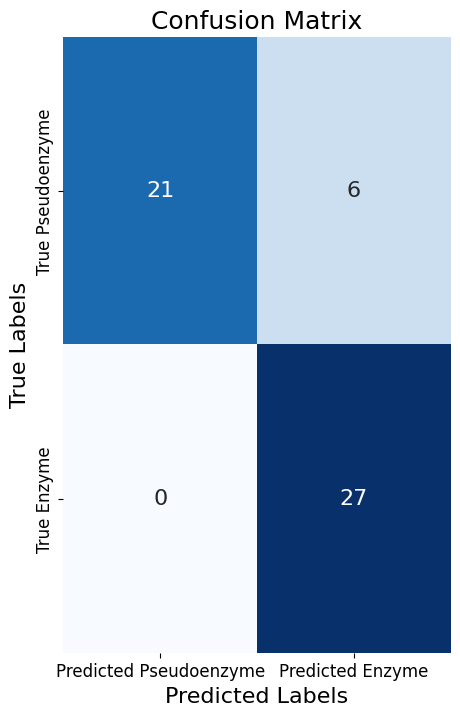

In [33]:
# %%
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


def plot_confusion_matrix_from_array(conf_matrix):


    plt.figure(figsize=(5, 8))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=["Predicted Pseudoenzyme", "Predicted Enzyme"],
        yticklabels=["True Pseudoenzyme", "True Enzyme"],
        annot_kws={'size': 16}  
    )
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel("Predicted Labels", fontsize=16)
    plt.ylabel("True Labels", fontsize=16)
    plt.title("Confusion Matrix", fontsize=18)
    plt.show()



plot_confusion_matrix_from_array(scores["Confusion Matrix"])

